In [1]:
pip install -q datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
# Loading The MNIST Dataset From Hugging Face
dataset = load_dataset("ylecun/mnist")

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [5]:
x_data_train = dataset['train']['image']
y_data_train = dataset['train']['label']
x_data_test = dataset['test']['image']
y_data_test = dataset['test']['label']

In [6]:
print(x_data_train[:5])

[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F5069496200>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F5069496E30>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F505C8CD5A0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F505C8CD8D0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F505C8CD930>]


In [7]:
x_data_train = [ToTensor()(img).squeeze() for img in x_data_train]
x_data_test = [ToTensor()(img).squeeze() for img in x_data_test]

In [8]:
example = x_data_train[0].numpy()

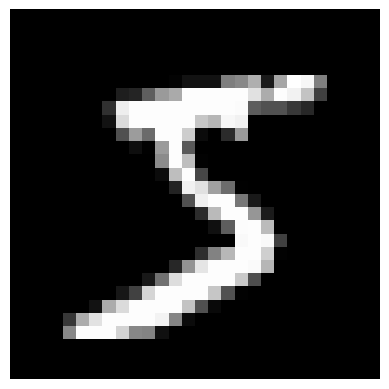

In [9]:
plt.imshow(example,cmap='gray')
plt.axis('off')  # Hide the axes
plt.show()

In [10]:
# Reshape
x_data_train = [img.reshape((-1,)) for img in x_data_train]
x_data_test = [img.reshape((-1,)) for img in x_data_test]

In [11]:
x_data_train = torch.stack(x_data_train)
x_data_test = torch.stack(x_data_test)

In [12]:
x_data_train.dtype

torch.float32

In [13]:
type(y_data_test)

list

In [14]:
y_data_train = torch.tensor(y_data_train)
y_data_test = torch.tensor(y_data_test)

In [15]:
print(len(x_data_train),len(y_data_train))

60000 60000


In [16]:
x_data_train.shape,y_data_train.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [17]:
# Building My NeuralNetwork
class NeuralNetwork(torch.nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super().__init__()
        self.layers = torch.nn.Sequential(
            
            # 1st hidden layer
            torch.nn.Linear(num_inputs,30),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(30,20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20,num_outputs)
        )

    def forward(self,x):
        logits = self.layers(x)
        return logits

In [18]:
# Define Data Class
class dataset(Dataset):
    def __init__(self,X,Y):
        self.features = X
        self.labels = Y
    def __getitem__(self,index):
        one = self.features[index]
        two = self.labels[index]
        return one,two
    def __len__(self):
        return self.labels.shape[0]
train_ds = dataset(x_data_train,y_data_train)
test_ds = dataset(x_data_test,y_data_test)

In [19]:
# Data Loader
torch.manual_seed(123)
train_loader = DataLoader(
    dataset = train_ds,
    shuffle = True,
    batch_size = 500,
    num_workers = 0,
    drop_last = True,
    )

In [20]:
# Training
import torch.nn.functional as F
torch.manual_seed(123)
model = NeuralNetwork(784,10)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)

num_epochs = 200
for i in range(num_epochs):
    model.train()
    for batch ,(features,labels) in enumerate(train_loader):
        logits = model(features)
        loss = F.cross_entropy(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"epochs {i+1:03d}/{num_epochs:03d}"
        f" |  batch {batch+1:03d}/{len(train_loader):03d}"
        f" | loss: {loss:.2f}" )

epochs 001/200 |  batch 001/120 | loss: 2.30
epochs 001/200 |  batch 002/120 | loss: 2.31
epochs 001/200 |  batch 003/120 | loss: 2.31
epochs 001/200 |  batch 004/120 | loss: 2.30
epochs 001/200 |  batch 005/120 | loss: 2.29
epochs 001/200 |  batch 006/120 | loss: 2.29
epochs 001/200 |  batch 007/120 | loss: 2.29
epochs 001/200 |  batch 008/120 | loss: 2.29
epochs 001/200 |  batch 009/120 | loss: 2.28
epochs 001/200 |  batch 010/120 | loss: 2.28
epochs 001/200 |  batch 011/120 | loss: 2.28
epochs 001/200 |  batch 012/120 | loss: 2.27
epochs 001/200 |  batch 013/120 | loss: 2.27
epochs 001/200 |  batch 014/120 | loss: 2.28
epochs 001/200 |  batch 015/120 | loss: 2.27
epochs 001/200 |  batch 016/120 | loss: 2.26
epochs 001/200 |  batch 017/120 | loss: 2.26
epochs 001/200 |  batch 018/120 | loss: 2.25
epochs 001/200 |  batch 019/120 | loss: 2.25
epochs 001/200 |  batch 020/120 | loss: 2.25
epochs 001/200 |  batch 021/120 | loss: 2.24
epochs 001/200 |  batch 022/120 | loss: 2.24
epochs 001

In [21]:
# Predcition Accuracy
def compute_accuracy(model,test_loader):
    correct = 0
    tatal_examples = 0
    model.eval()
    for idx ,(feature,lables) in enumerate(test_loader):
        with torch.no_grad():
            logits = model(features)
        predictions = torch.argmax(logits,dim=1)
        compare = labels == predictions
        correct += torch.sum(compare)
        tatal_examples += len(compare)
    return (correct/tatal_examples).item()

In [22]:
torch.manual_seed(123)
test_loader = DataLoader(
    dataset = test_ds,
    shuffle = False,
    batch_size = 500,
    num_workers = 0,
    )

In [23]:
accuracy_test = compute_accuracy(model,test_loader)

In [24]:
accuracy_test

1.0

In [25]:
accuracy_train = compute_accuracy(model,test_loader)
accuracy_train

1.0

In [26]:
# save the model
torch.save(model.state_dict(),"model.pth")

In [27]:
Model = NeuralNetwork(784,10)

In [29]:
Model.load_state_dict(torch.load("model.pth")) 

<All keys matched successfully>